In [0]:
import pyspark.sql.functions as F
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
from pyspark.sql.functions import to_date
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import DoubleType

from matplotlib import pyplot
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import precision_score, recall_score, auc
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.ml.evaluation as ev
import matplotlib.pyplot as plt
from pyspark.ml.classification import RandomForestClassifier

In [0]:
#Annual
annual_pivot = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/annual_day_of_week_counts_pivot.csv")
annual_features = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/annual_features.csv")
#Monthly
days_since_last_txn = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/days_since_last_txn.csv")
mth_day_counts = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/mth_day_counts.csv")
mth_rolling_features = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/mth_rolling_features.xlsx")
#retail_data_response
retail_data_response = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/retail_data_response.csv")

In [0]:
# join the annual table
annual_retail_data = annual_features.join(annual_pivot, on=['customer_id'])
annual_retail_data = annual_retail_data.join(retail_data_response, on=['customer_id'])
annual_retail_data = annual_retail_data.fillna(0)
annual_retail_data.display()

customer_id 2011_ann_txn_amt_sum 2011_ann_txn_amt_ave 2011_ann_txn_amt_std 2011_ann_txn_amt_var 2011_ann_txn_amt_sem 2011_ann_txn_amt_max 2011_ann_txn_amt_min 2011_ann_txn_amt_cnt 2012_ann_txn_amt_sum 2012_ann_txn_amt_ave 2012_ann_txn_amt_std 2012_ann_txn_amt_var 2012_ann_txn_amt_sem 2012_ann_txn_amt_max 2012_ann_txn_amt_min 2012_ann_txn_amt_cnt 2013_ann_txn_amt_sum 2013_ann_txn_amt_ave 2013_ann_txn_amt_std 2013_ann_txn_amt_var 2013_ann_txn_amt_sem 2013_ann_txn_amt_max 2013_ann_txn_amt_min 2013_ann_txn_amt_cnt 2014_ann_txn_amt_sum 2014_ann_txn_amt_ave 2014_ann_txn_amt_std 2014_ann_txn_amt_var 2014_ann_txn_amt_sem 2014_ann_txn_amt_max 2014_ann_txn_amt_min 2014_ann_txn_amt_cnt 2015_ann_txn_amt_sum 2015_ann_txn_amt_ave 2015_ann_txn_amt_std 2015_ann_txn_amt_var 2015_ann_txn_amt_sem 2015_ann_txn_amt_max 2015_ann_txn_amt_min 2015_ann_txn_amt_cnt Friday_cnt_2011 Friday_cnt_2012 Friday_cnt_2013 Friday_cnt_2014 Friday_cnt_2015 Monday_cnt_2011 Monday_cnt_2012 Monday_cnt_2013 Monday_cnt_2014 Monday_cnt_2015 Saturday_cnt_2011 Saturday_cnt_2012 Saturday_cnt_2013 Saturday_cnt_2014 Saturday_cnt_2015 Sunday_cnt_2011 Sunday_cnt_2012 Sunday_cnt_2013 Sunday_cnt_2014 Sunday_cnt_2015 Thursday_cnt_2011 Thursday_cnt_2012 Thursday_cnt_2013 Thursday_cnt_2014 Thursday_cnt_2015 Tuesday_cnt_2011 Tuesday_cnt_2012 Tuesday_cnt_2013 Tuesday_cnt_2014 Tuesday_cnt_2015 Wednesday_cnt_2011 Wednesday_cnt_2012 Wednesday_cnt_2013 Wednesday_cnt_2014 Wednesday_cnt_2015 response CS1112 212 70.66666666666667 22.03028218914441 485.33333333333337 17.98765008430939 96 56 3 337 67.4 12.720062892926277 161.8 11.377170122662314 81 52 5 212 70.66666666666667 34.50120770833006 1190.3333333333333 28.1701181317288 105 36 3 212 70.66666666666667 16.862186493255653 284.33333333333337 13.767917618708923 90 59 3 39 39.0 0.0 0.0 0.0 39 39 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 3 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 CS1113 244 81.33333333333333 21.07921567168317 444.33333333333337 17.21110752456745 94 57 3 374 74.8 17.035257556021865 290.20000000000005 15.236797563792729 95 51 5 426 85.2 13.0843417870369 171.2 11.702991070662234 97 65 5 226 56.5 27.958302285129307 781.6666666666666 24.212600025606502 97 36 4 220 73.33333333333333 27.300793639257694 745.3333333333334 22.29100466306732 98 44 3 1 2 0 0 0 1 1 1 0 2 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 2 3 0 0 1 1 0 1 0 CS1114 426 85.2 9.731392500562293 94.70000000000003 8.704022058795578 97 76 5 150 75.0 31.11269837220809 968.0 22.0 97 53 2 352 70.4 24.88573888796553 619.3 22.25848152952038 105 43 5 425 70.83333333333333 26.947479783212874 726.1666666666666 24.599570908633524 95 37 6 79 79.0 0.0 0.0 0.0 79 79 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 2 0 1 0 0 0 1 0 2 0 1 1 0 1 CS1115 261 87.0 15.0 225.0 12.24744871391589 102 72 3 473 67.57142857142857 21.846869667888676 477.2857142857143 20.226271055642624 104 41 7 557 79.57142857142857 10.533393610436333 110.95238095238098 9.752027523357722 94 66 7 313 78.25 22.632940595512547 512.2499999999999 19.600701518057967 98 50 4 55 55.0 0.0 0.0 0.0 55 55 1 0 1 0 0 0 0 1 1 0 0 1 0 2 0 0 1 2 0 0 0 0 1 2 2 1 0 1 0 0 0 1 1 2 2 0 1 CS1116 235 58.75 21.203380233664003 449.5833333333333 18.362665928453854 87 41 4 230 76.66666666666667 30.138568866708543 908.3333333333334 24.608038433722335 105 45 3 59 59.0 0.0 0.0 0.0 59 59 1 333 66.6 25.234896472940004 636.8 22.570777567465413 96 40 5 0 0.0 0.0 0.0 0.0 0 0 0 1 1 1 3 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 CS1117 213 71.0 26.057628441590765 679.0 21.275964529643932 98 46 3 196 65.33333333333333 32.715949219506584 1070.3333333333335 26.71246067953223 100 35 3 347 69.4 17.38677658451963 302.30000000000007 15.551205741035004 94 49 5 429 71.5 15.871357849913158 251.9 14.488501187723548 94 56 6 0 0.0 0.0 0.0 0.0 0 0 0 1 1 0 0 0 0 1 2 0 0 0 0 0 1 0 0 0 3 1 0 1 0 0 1 0 0 0 0 2 0 1 1 0 1 0 0 CS1118 124 62.0 26.870057685088806 722.0 19.0 81 43 2 63 63.0 0.0 0.0 0.0 63 63 1 144 72.0 7.0710678118654755 50.0 5.0 77 67 2 620 68.88888888888889 2

In [0]:
retail_data_response = retail_data_response.withColumnRenamed("customer_id","CLNT_NO")
# join the monthly table
monthly_retail_data = retail_data_response.join(mth_rolling_features, on=['CLNT_NO'])
monthly_retail_data = monthly_retail_data.join(mth_day_counts ,on=['CLNT_NO','ME_DT'])
monthly_retail_data = monthly_retail_data.join(days_since_last_txn, on=['CLNT_NO','ME_DT'])
monthly_retail_data = monthly_retail_data.fillna(0)
monthly_retail_data.display()

CLNT_NO ME_DT response mth_txn_amt_sum mth_txn_amt_cnt amt_sum_3M amt_mean_3M amt_max_3M txn_cnt_sum_3M txn_cnt_mean_3M txn_cnt_max_3M amt_sum_6M amt_mean_6M amt_max_6M txn_cnt_sum_6M txn_cnt_mean_6M txn_cnt_max_6M amt_sum_12M amt_mean_12M amt_max_12M txn_cnt_sum_12M txn_cnt_mean_12M txn_cnt_max_12M cnt_Friday cnt_Monday cnt_Saturday cnt_Sunday cnt_Thursday cnt_Tuesday cnt_Wednesday days_since_last_txn CS1112 2011-05-31 0 0 0 0 0.0 0 0 0.0 0 0 0.0 0 0 0.0 0 0 0.0 0 0 0.0 0 0 0 0 0 0 0 0 null CS1112 2011-06-30 0 56 1 56 28.0 56 1 0.5 1 56 28.0 56 1 0.5 1 56 28.0 56 1 0.5 1 0 0 0 0 0 0 1 15 CS1112 2011-07-31 0 0 0 56 18.666666666666668 56 1 0.3333333333333333 1 56 18.666666666666668 56 1 0.3333333333333333 1 56 18.666666666666668 56 1 0.3333333333333333 1 0 0 0 0 0 0 0 46 CS1112 2011-08-31 0 96 1 152 50.666666666666664 96 2 0.6666666666666666 1 152 38.0 96 2 0.5 1 152 38.0 96 2 0.5 1 1 0 0 0 0 0 0 12 CS1112 2011-09-30 0 0 0 96 32.0 96 1 0.3333333333333333 1 152 30.4 96 2 0.4 1 152 30.4 96 2 0.4 1 0 0 0 0 0 0 0 42 CS1112 2011-10-31 0 60 1 156 52.0 96 2 0.6666666666666666 1 212 35.333333333333336 96 3 0.5 1 212 35.333333333333336 96 3 0.5 1 0 0 0 1 0 0 0 29 CS1112 2011-11-30 0 0 0 60 20.0 60 1 0.3333333333333333 1 212 35.333333333333336 96 3 0.5 1 212 30.285714285714285 96 3 0.42857142857142855 1 0 0 0 0 0 0 0 59 CS1112 2011-12-31 0 0 0 60 20.0 60 1 0.3333333333333333 1 156 26.0 96 2 0.3333333333333333 1 212 26.5 96 3 0.375 1 0 0 0 0 0 0 0 90 CS1112 2012-01-31 0 0 0 0 0.0 0 0 0.0 0 156 26.0 96 2 0.3333333333333333 1 212 23.555555555555557 96 3 0.3333333333333333 1 0 0 0 0 0 0 0 121 CS1112 2012-02-29 0 0 0 0 0.0 0 0 0.0 0 60 10.0 60 1 0.16666666666666666 1 212 21.2 96 3 0.3 1 0 0 0 0 0 0 0 150 CS1112 2012-03-31 0 0 0 0 0.0 0 0 0.0 0 60 10.0 60 1 0.16666666666666666 1 212 19.272727272727273 96 3 0.2727272727272727 1 0 0 0 0 0 0 0 181 CS1112 2012-04-30 0 56 1 56 18.666666666666668 56 1 0.3333333333333333 1 56 9.333333333333334 56 1 0.16666666666666666 1 268 22.333333333333332 96 4 0.3333333333333333 1 0 0 0 1 0 0 0 22 CS1112 2012-05-31 0 0 0 56 18.666666666666668 56 1 0.3333333333333333 1 56 9.333333333333334 56 1 0.16666666666666666 1 268 22.333333333333332 96 4 0.3333333333333333 1 0 0 0 0 0 0 0 53 CS1112 2012-06-30 0 52 1 108 36.0 56 2 0.6666666666666666 1 108 18.0 56 2 0.3333333333333333 1 264 22.0 96 4 0.3333333333333333 1 0 0 0 1 0 0 0 6 CS1112 2012-07-31 0 81 1 133 44.333333333333336 81 2 0.6666666666666666 1 189 31.5 81 3 0.5 1 345 28.75 96 5 0.4166666666666667 1 0 0 0 0 0 1 0 28 CS1112 2012-08-31 0 0 0 133 44.333333333333336 81 2 0.6666666666666666 1 189 31.5 81 3 0.5 1 249 20.75 81 4 0.3333333333333333 1 0 0 0 0 0 0 0 59 CS1112 2012-09-30 0 72 1 153 51.0 81 2 0.6666666666666666 1 261 43.5 81 4 0.6666666666666666 1 321 26.75 81 5 0.4166666666666667 1 0 0 0 1 0 0 0 14 CS1112 2012-10-31 0 0 0 72 24.0 72 1 0.3333333333333333 1 205 34.166666666666664 81 3 0.5 1 261 21.75 81 4 0.3333333333333333 1 0 0 0 0 0 0 0 45 CS1112 2012-11-30 0 0 0 72 24.0 72 1 0.3333333333333333 1 205 34.166666666666664 81 3 0.5 1 261 21.75 81 4 0.3333333333333333 1 0 0 0 0 0 0 0 75 CS1112 2012-12-31 0 76 1 76 25.333333333333332 76 1 0.3333333333333333 1 229 38.166666666666664 81 3 0.5 1 337 28.083333333333332 81 5 0.4166666666666667 1 0 0 1 0 0 0 0 16 CS1112 2013-01-31 0 0 0 76 25.333333333333332 76 1 0.3333333333333333 1 148 24.666666666666668 76 2 0.3333333333333333 1 337 28.083333333333332 81 5 0.4166666666666667 1 0 0 0 0 0 0 0 47 CS1112 2013-02-28 0 0 0 76 25.333333333333332 76 1 0.3333333333333333 1 148 24.666666666666668 76 2 0.3333333333333333 1 337 28.083333333333332 81 5 0.4166666666666667 1 0 0 0 0 0 0 0 75 CS1112 2013-03-31 0 105 1 105 35.0 105 1 0.3333333333333333 1 181 30.166666666666668 105 2 0.3333333333333333 1 442 36.833333333333336 105 6 0.5 1 1 0 0 0 0 0 0 30 CS1112 2013-04-30 0 0 0 105 35.0 105 1 0.3333333333333333 1 181 30.166666666666668 105 2 0.3333333333333333 1 386 32.166666666666664 105 5 0.4166666666666667 1 0 0 0 0 0 0 0 60 CS

In [0]:
#1.2.2
#Since Pyspark does not need to split data in to X and y, we will not do that here.
## split for training and testing data
train_monthly, test_monthly = monthly_retail_data.randomSplit(weights=[1/3,2/3], seed=1147)
train_annual, test_annual = annual_retail_data.randomSplit(weights=[1/3,2/3], seed=1147)



In [0]:
#transfer the data type to double type
for i in train_annual.columns:
    train_annual = train_annual.withColumn(i, train_annual[i].cast('double'))
    
for i in test_annual.columns:
    test_annual = test_annual.withColumn(i, test_annual[i].cast('double'))

#Drop customer_id column
train_annual=train_annual.drop('customer_id')
test_annual=test_annual.drop('customer_id')

#Annual:
assembler_annual = VectorAssembler(inputCols=[
 '2011_ann_txn_amt_sum',
 '2011_ann_txn_amt_ave',
 '2011_ann_txn_amt_std',
 '2011_ann_txn_amt_var',
 '2011_ann_txn_amt_sem',
 '2011_ann_txn_amt_max',
 '2011_ann_txn_amt_min',
 '2011_ann_txn_amt_cnt',
 '2012_ann_txn_amt_sum',
 '2012_ann_txn_amt_ave',
 '2012_ann_txn_amt_std',
 '2012_ann_txn_amt_var',
 '2012_ann_txn_amt_sem',
 '2012_ann_txn_amt_max',
 '2012_ann_txn_amt_min',
 '2012_ann_txn_amt_cnt',
 '2013_ann_txn_amt_sum',
 '2013_ann_txn_amt_ave',
 '2013_ann_txn_amt_std',
 '2013_ann_txn_amt_var',
 '2013_ann_txn_amt_sem',
 '2013_ann_txn_amt_max',
 '2013_ann_txn_amt_min',
 '2013_ann_txn_amt_cnt',
 '2014_ann_txn_amt_sum',
 '2014_ann_txn_amt_ave',
 '2014_ann_txn_amt_std',
 '2014_ann_txn_amt_var',
 '2014_ann_txn_amt_sem',
 '2014_ann_txn_amt_max',
 '2014_ann_txn_amt_min',
 '2014_ann_txn_amt_cnt',
 '2015_ann_txn_amt_sum',
 '2015_ann_txn_amt_ave',
 '2015_ann_txn_amt_std',
 '2015_ann_txn_amt_var',
 '2015_ann_txn_amt_sem',
 '2015_ann_txn_amt_max',
 '2015_ann_txn_amt_min',
 '2015_ann_txn_amt_cnt',
 'Friday_cnt_2011',
 'Friday_cnt_2012',
 'Friday_cnt_2013',
 'Friday_cnt_2014',
 'Friday_cnt_2015',
 'Monday_cnt_2011',
 'Monday_cnt_2012',
 'Monday_cnt_2013',
 'Monday_cnt_2014',
 'Monday_cnt_2015',
 'Saturday_cnt_2011',
 'Saturday_cnt_2012',
 'Saturday_cnt_2013',
 'Saturday_cnt_2014',
 'Saturday_cnt_2015',
 'Sunday_cnt_2011',
 'Sunday_cnt_2012',
 'Sunday_cnt_2013',
 'Sunday_cnt_2014',
 'Sunday_cnt_2015',
 'Thursday_cnt_2011',
 'Thursday_cnt_2012',
 'Thursday_cnt_2013',
 'Thursday_cnt_2014',
 'Thursday_cnt_2015',
 'Tuesday_cnt_2011',
 'Tuesday_cnt_2012',
 'Tuesday_cnt_2013',
 'Tuesday_cnt_2014',
 'Tuesday_cnt_2015',
 'Wednesday_cnt_2011',
 'Wednesday_cnt_2012',
 'Wednesday_cnt_2013',
 'Wednesday_cnt_2014',
 'Wednesday_cnt_2015'], outputCol='features')

#For train
VecTrainDF_ann = assembler_annual.transform(train_annual)
VecTrainDF_ann = VecTrainDF_ann.fillna(0)
#For test
VecTestDF_ann = assembler_annual.transform(test_annual)
VecTestDF_ann = VecTestDF_ann.fillna(0)


In [0]:
##Standardize the annual data using standardscale

#annual train:
scaler = StandardScaler(inputCol="features", outputCol='scaledfeatures', withMean=True, withStd=True)
scalerModel = scaler.fit(VecTrainDF_ann)
train_annual_scaled = scalerModel.transform(VecTrainDF_ann)

#annual test:
scalerModel = scaler.fit(VecTestDF_ann)
test_annual_scaled = scalerModel.transform(VecTestDF_ann)

#Drop customer_id column
train_annual_scaled=train_annual_scaled.drop('customer_id')
test_annual_scaled=test_annual_scaled.drop('customer_id')

In [0]:
#Monthly
for i in train_monthly.columns:
    train_monthly = train_monthly.withColumn(i, train_monthly[i].cast(DoubleType()))
    
for j in test_monthly.columns:
    test_monthly = test_monthly.withColumn(j, test_monthly[j].cast(DoubleType()))
  

train_monthly=train_monthly.na.fill(value=0,subset=["days_since_last_txn"])
test_monthly=test_monthly.na.fill(value=0,subset=["days_since_last_txn"])

In [0]:
#Monthly
MonVecAssembler = VectorAssembler(inputCols=['mth_txn_amt_sum',
 'mth_txn_amt_cnt',
 'amt_sum_3M',
 'amt_mean_3M',
 'amt_max_3M',
 'txn_cnt_sum_3M',
 'txn_cnt_mean_3M',
 'txn_cnt_max_3M',
 'amt_sum_6M',
 'amt_mean_6M',
 'amt_max_6M',
 'txn_cnt_sum_6M',
 'txn_cnt_mean_6M',
 'txn_cnt_max_6M',
 'amt_sum_12M',
 'amt_mean_12M',
 'amt_max_12M',
 'txn_cnt_sum_12M',
 'txn_cnt_mean_12M',
 'txn_cnt_max_12M',
 'cnt_Friday',
 'cnt_Monday',
 'cnt_Saturday',
 'cnt_Sunday',
 'cnt_Thursday',
 'cnt_Tuesday',
 'cnt_Wednesday',
 'days_since_last_txn'], outputCol='features')
#Train
VecTrainDF_mon = MonVecAssembler.transform(train_monthly)
VecTrainDF_mon = VecTrainDF_mon.fillna(0)

#Test
VecTestDF_mon = MonVecAssembler.transform(test_monthly)
VecTestDF_mon = VecTestDF_mon.fillna(0)

In [0]:
#Standardize the monthly data using standardscaler
scaler = StandardScaler(inputCol="features", outputCol='scaledfeatures', withMean=True, withStd=True)
#Train
scalerModel = scaler.fit(VecTrainDF_mon)
train_monthly_scaled = scalerModel.transform(VecTrainDF_mon)

#test:
scalerModel = scaler.fit(VecTestDF_mon)
test_monthly_scaled = scalerModel.transform(VecTestDF_mon)

#Drop the index columns
train_monthly_scaled=train_monthly_scaled.drop('CLNT_NO','ME_DT')
test_monthly_scaled=test_monthly_scaled.drop('CLNT_NO','ME_DT')

In [0]:

test_monthly_scaled.display()

response mth_txn_amt_sum mth_txn_amt_cnt amt_sum_3M amt_mean_3M amt_max_3M txn_cnt_sum_3M txn_cnt_mean_3M txn_cnt_max_3M amt_sum_6M amt_mean_6M amt_max_6M txn_cnt_sum_6M txn_cnt_mean_6M txn_cnt_max_6M amt_sum_12M amt_mean_12M amt_max_12M txn_cnt_sum_12M txn_cnt_mean_12M txn_cnt_max_12M cnt_Friday cnt_Monday cnt_Saturday cnt_Sunday cnt_Thursday cnt_Tuesday cnt_Wednesday days_since_last_txn features scaledfeatures 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 28, indices -> List(), values -> List()) Map(vectorType -> dense, length -> 28, values -> List(-0.5762904173726827, -0.6175285436831974, -0.9520211442029098, -0.9508267866748122, -1.056704361562946, -1.0397873343097586, -1.0394417862210543, -1.1518117687573444, -1.2388630707988926, -1.2374243286663147, -1.4952715168989836, -1.3797010948976944, -1.3824724346595538, -1.6290115147353266, -1.470425143574172, -1.5013794001023713, -1.8447009831972119, -1.6671390733942537, -1.722692509630906, -1.9622326544555329, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, -0.23517599228116853, -0.9218481391821653)) 0.0 56.0 1.0 56.0 28.0 56.0 1.0 0.5 1.0 56.0 28.0 56.0 1.0 0.5 1.0 56.0 28.0 56.0 1.0 0.5 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 15.0 Map(vectorType -> dense, length -> 28, values -> List(56.0, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15.0)) Map(vectorType -> dense, length -> 28, values -> List(0.7133437229670027, 0.9858511230081272, -0.233271563587982, 0.11052903072281997, -0.02672616697052824, -0.12883038606194686, 0.307361695407132, 0.19299224188438568, -0.7561498203272214, 0.1491720400612651, -0.4830480968765763, -0.7559547239095237, 0.4155949159776578, -0.2685751507636324, -1.163468437824037, 0.18851469537446144, -0.8556729551653798, -1.2632252778269324, 0.5284633730396396, -0.6370601970704955, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, 3.9984040794332287, -0.725287775217673)) 0.0 0.0 0.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 46.0 Map(vectorType -> dense, length -> 28, values -> List(0.0, 0.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0)) Map(vectorType -> dense, length -> 28, values -> List(-0.5762904173726827, -0.6175285436831974, -0.233271563587982, -0.24325624174305738, -0.02672616697052824, -0.12883038606194686, -0.14157279846893017, 0.19299224188438568, -0.7561498203272214, -0.31302674951459475, -0.4830480968765763, -0.7559547239095237, -0.18376086756807947, -0.2685751507636324, -1.163468437824037, -0.3747833364511494, -0.8556729551653798, -1.2632252778269324, -0.2219219211838757, -0.6370601970704955, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, -0.23517599228116853, -0.31906302302438877)) 0.0 60.0 1.0 156.0 52.0 96.0 2.0 0.6666666666666666 1.0 212.0 35.333333333333336 96.0 3.0 0.5 1.0 212.0 35.333333333333336 96.0 3.0 0.5 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 29.0 Map(vectorType -> dense, length -> 28, values -> List(60.0, 1.0, 156.0, 52.0, 96.0, 2.0, 0.6666666666666666, 1.0, 212.0, 35.333333333333336, 96.0, 3.0, 0.5, 1.0, 212.0, 35.333333333333336, 96.0, 3.0, 0.5, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 29.0)) Map(vectorType -> dense, length -> 28, values -> List(0.8054604472769802, 0.9858511230081272, 1.0502098303672462, 1.020262588492219, 0.7089725434526273, 0.7821265621858647, 0.7562961892831941, 0.192992241

#Logistic Regression Monthly

In [0]:
# part 1.2.4 model tunning
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

logistic =  LogisticRegression(featuresCol='scaledfeatures', labelCol='response')
evaluate=BinaryClassificationEvaluator(labelCol = 'response')
gridsearch =  ParamGridBuilder().addGrid(logistic.regParam, [0.01, 0.1, 0.2,0.3]).build()
crossval = CrossValidator(estimator=logistic,
                          estimatorParamMaps=gridsearch,
                          evaluator = evaluate,
                          numFolds=2)  
Model_cross = crossval.fit(train_monthly_scaled)
prediction = Model_cross.transform(test_monthly_scaled)


In [0]:
print(list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps())))
print('The best hyperparameter is ','0.01 (based on grid search)')

# get the best hyperparameter inside
logistic =  LogisticRegression(featuresCol='scaledfeatures', labelCol='response',regParam = 0.01)
logistic_monthly_model = logistic.fit(train_monthly_scaled)
# transform the test data
logis_test_monthly= logistic_monthly_model.transform(test_monthly_scaled) 
# transform the train data
logis_train_monthly= logistic_monthly_model.transform(train_monthly_scaled) 

[(0.6303543808760022, {Param(parent='LogisticRegression_b4d769b4ae0d', name='regParam', doc='regularization parameter (>= 0).'): 0.01}), (0.6228536842427301, {Param(parent='LogisticRegression_b4d769b4ae0d', name='regParam', doc='regularization parameter (>= 0).'): 0.1}), (0.6194334113040183, {Param(parent='LogisticRegression_b4d769b4ae0d', name='regParam', doc='regularization parameter (>= 0).'): 0.2}), (0.6173996887301967, {Param(parent='LogisticRegression_b4d769b4ae0d', name='regParam', doc='regularization parameter (>= 0).'): 0.3})]
The best hyperparameter is  0.01 (based on grid search)


Feature: 0, Score: 0.01332
Feature: 1, Score: -0.01738
Feature: 2, Score: 0.02159
Feature: 3, Score: 0.00591
Feature: 4, Score: 0.02536
Feature: 5, Score: -0.02004
Feature: 6, Score: -0.02579
Feature: 7, Score: -0.04724
Feature: 8, Score: 0.06728
Feature: 9, Score: 0.04146
Feature: 10, Score: 0.05042
Feature: 11, Score: -0.03672
Feature: 12, Score: -0.04133
Feature: 13, Score: -0.02785
Feature: 14, Score: 0.19533
Feature: 15, Score: 0.13897
Feature: 16, Score: 0.06957
Feature: 17, Score: -0.02120
Feature: 18, Score: -0.03936
Feature: 19, Score: -0.01179
Feature: 20, Score: 0.00407
Feature: 21, Score: -0.01154
Feature: 22, Score: -0.01091
Feature: 23, Score: 0.00116
Feature: 24, Score: -0.01012
Feature: 25, Score: -0.01841
Feature: 26, Score: -0.00037
Feature: 27, Score: -0.13866


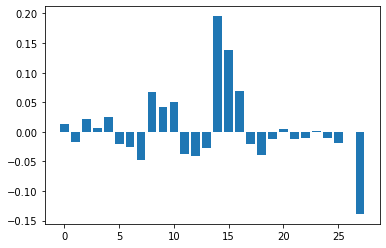

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = logistic_monthly_model.coefficients
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.06290229828179617, 0.07225217645894721, 0.06721152805785191, 0.1005053211765683, 0.09275215207264298, 0.08603495622309698, 0.07439619163149236, 0.0698691192295604, 0.09065813472562101, 0.08657056599031032, 0.09692085840258924, 0.08534977438612323, 0.10331039980570522, 0.0915713931032549, 0.08713668678932462, 0.10035922316892609, 0.13377885103988174, 0.11711188594664079, 0.11141221050407413, 0.09948233500694059, 0.0933788823176150

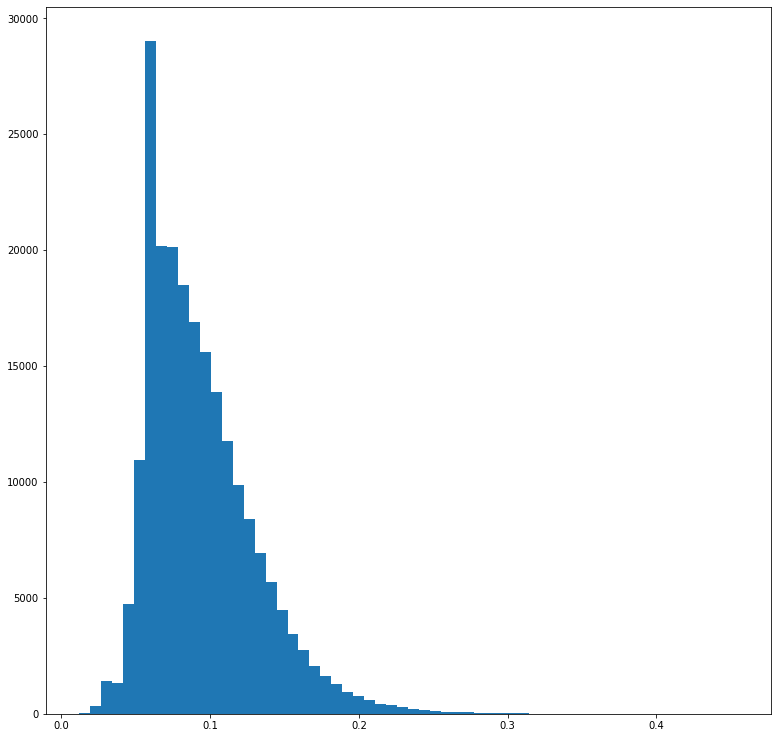

In [0]:
#1.2.6
#ToPandas and get the probility list

pd_logis=logis_test_monthly.select('probability').toPandas()
pd_logis.explode("probability")
# get the list together
import matplotlib.pyplot as plt
test =[]
for i in range (0,215679):
    p=pd_logis.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)


In [0]:
logis_test_monthly.display()

response mth_txn_amt_sum mth_txn_amt_cnt amt_sum_3M amt_mean_3M amt_max_3M txn_cnt_sum_3M txn_cnt_mean_3M txn_cnt_max_3M amt_sum_6M amt_mean_6M amt_max_6M txn_cnt_sum_6M txn_cnt_mean_6M txn_cnt_max_6M amt_sum_12M amt_mean_12M amt_max_12M txn_cnt_sum_12M txn_cnt_mean_12M txn_cnt_max_12M cnt_Friday cnt_Monday cnt_Saturday cnt_Sunday cnt_Thursday cnt_Tuesday cnt_Wednesday days_since_last_txn features scaledfeatures rawPrediction probability prediction 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 28, indices -> List(), values -> List()) Map(vectorType -> dense, length -> 28, values -> List(-0.5762904173726827, -0.6175285436831974, -0.9520211442029098, -0.9508267866748122, -1.056704361562946, -1.0397873343097586, -1.0394417862210543, -1.1518117687573444, -1.2388630707988926, -1.2374243286663147, -1.4952715168989836, -1.3797010948976944, -1.3824724346595538, -1.6290115147353266, -1.470425143574172, -1.5013794001023713, -1.8447009831972119, -1.6671390733942537, -1.722692509630906, -1.9622326544555329, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, -0.23517599228116853, -0.9218481391821653)) Map(vectorType -> dense, length -> 2, values -> List(2.701204845879586, -2.701204845879586)) Map(vectorType -> dense, length -> 2, values -> List(0.9370977017182038, 0.06290229828179617)) 0.0 0.0 56.0 1.0 56.0 28.0 56.0 1.0 0.5 1.0 56.0 28.0 56.0 1.0 0.5 1.0 56.0 28.0 56.0 1.0 0.5 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 15.0 Map(vectorType -> dense, length -> 28, values -> List(56.0, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 56.0, 28.0, 56.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15.0)) Map(vectorType -> dense, length -> 28, values -> List(0.7133437229670027, 0.9858511230081272, -0.233271563587982, 0.11052903072281997, -0.02672616697052824, -0.12883038606194686, 0.307361695407132, 0.19299224188438568, -0.7561498203272214, 0.1491720400612651, -0.4830480968765763, -0.7559547239095237, 0.4155949159776578, -0.2685751507636324, -1.163468437824037, 0.18851469537446144, -0.8556729551653798, -1.2632252778269324, 0.5284633730396396, -0.6370601970704955, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, 3.9984040794332287, -0.725287775217673)) Map(vectorType -> dense, length -> 2, values -> List(2.552597503445729, -2.552597503445729)) Map(vectorType -> dense, length -> 2, values -> List(0.9277478235410528, 0.07225217645894721)) 0.0 0.0 0.0 0.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 56.0 18.666666666666668 56.0 1.0 0.3333333333333333 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 46.0 Map(vectorType -> dense, length -> 28, values -> List(0.0, 0.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 56.0, 18.666666666666668, 56.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0)) Map(vectorType -> dense, length -> 28, values -> List(-0.5762904173726827, -0.6175285436831974, -0.233271563587982, -0.24325624174305738, -0.02672616697052824, -0.12883038606194686, -0.14157279846893017, 0.19299224188438568, -0.7561498203272214, -0.31302674951459475, -0.4830480968765763, -0.7559547239095237, -0.18376086756807947, -0.2685751507636324, -1.163468437824037, -0.3747833364511494, -0.8556729551653798, -1.2632252778269324, -0.2219219211838757, -0.6370601970704955, -0.2329039823248728, -0.23479779795575295, -0.2337997801733451, -0.2333399474246686, -0.235852420776739, -0.2345338414396674, -0.23517599228116853, -0.31906302302438877)) Map(vectorType -> dense, length -> 2, values -> List(2.6303336756709914, -2.6303336756709914)) Map(vectorType -> dense, length -> 2, values -> List(0.9327884719421481, 0.06721152805785191)) 0.0 0.0 60.0 1.0 1

In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =logis_test_monthly.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[18]: array([[195381.,      0.],
       [ 20298.,      0.]])

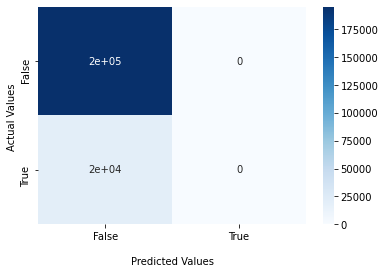

In [0]:
#Plot the confusion matrix
import seaborn as sns

ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_monthly_pred=logis_test_monthly.select('probability').toPandas()
pd_train_monthly_pred=logis_train_monthly.select('probability').toPandas()
print(pd_test_monthly_pred.count(),pd_train_monthly_pred.count())

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
probability    215679
dtype: int64 probability    107869
dtype: int64


In [0]:
test=[]
for i in range(215679):
    p = pd_test_monthly_pred.probability[i][1]
    test.append(p)

y_test_monthly = test_monthly.select('response').toPandas()

train=[]
for i in range(107869):
    p = pd_train_monthly_pred.probability[i][1]
    train.append(p)

y_train_monthly = train_monthly.select('response').toPandas()

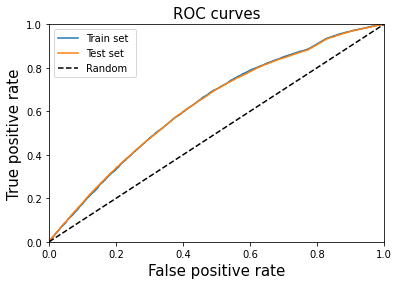

In [0]:

# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =logis_test_monthly.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
the Precision: 
the prediction Response of 1:  0.0
the prediction Response of 0:  0.9058879167651928
the Recall: 
the recall for Response of 1:  0.0
the recall for Response of 0:  1.0


#Logistic Regression Annual

In [0]:
logistic =  LogisticRegression(featuresCol='scaledfeatures', labelCol='response')
evaluate=BinaryClassificationEvaluator(labelCol = 'response')
gridsearch =  ParamGridBuilder().addGrid(logistic.regParam, [0.01, 0.1, 0.2,0.3]).build()
crossval = CrossValidator(estimator=logistic,
                          estimatorParamMaps=gridsearch,
                          evaluator = evaluate,
                          numFolds=2)  
Model_cross = crossval.fit(train_annual_scaled)
prediction = Model_cross.transform(test_annual_scaled)

In [0]:
print(list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps())))
print('The best hyperparameter is ','0.3 (based on grid search)')

# get the best hyperparameter inside
logistic =  LogisticRegression(featuresCol='scaledfeatures', labelCol='response',regParam = 0.3)
logistic_annual_model = logistic.fit(train_annual_scaled)
# transform the test data
logis_test_annual= logistic_annual_model.transform(test_annual_scaled) 
# transform the train data
logis_train_annual= logistic_annual_model.transform(train_annual_scaled) 

[(0.7304632221899731, {Param(parent='LogisticRegression_81297b2aea0b', name='regParam', doc='regularization parameter (>= 0).'): 0.01}), (0.7422356170625838, {Param(parent='LogisticRegression_81297b2aea0b', name='regParam', doc='regularization parameter (>= 0).'): 0.1}), (0.7443544987416653, {Param(parent='LogisticRegression_81297b2aea0b', name='regParam', doc='regularization parameter (>= 0).'): 0.2}), (0.7445724314938442, {Param(parent='LogisticRegression_81297b2aea0b', name='regParam', doc='regularization parameter (>= 0).'): 0.3})]
The best hyperparameter is  0.3 (based on grid search)


Feature: 0, Score: 0.00956
Feature: 1, Score: 0.02002
Feature: 2, Score: 0.00051
Feature: 3, Score: -0.00587
Feature: 4, Score: -0.00141
Feature: 5, Score: 0.01433
Feature: 6, Score: 0.02796
Feature: 7, Score: 0.00337
Feature: 8, Score: 0.00171
Feature: 9, Score: 0.03070
Feature: 10, Score: 0.01879
Feature: 11, Score: 0.01060
Feature: 12, Score: 0.01590
Feature: 13, Score: 0.02916
Feature: 14, Score: 0.02841
Feature: 15, Score: -0.00401
Feature: 16, Score: 0.07437
Feature: 17, Score: 0.03694
Feature: 18, Score: 0.01409
Feature: 19, Score: 0.00738
Feature: 20, Score: 0.02551
Feature: 21, Score: 0.04584
Feature: 22, Score: 0.01417
Feature: 23, Score: 0.06727
Feature: 24, Score: 0.09300
Feature: 25, Score: 0.03589
Feature: 26, Score: 0.01962
Feature: 27, Score: 0.00623
Feature: 28, Score: 0.03784
Feature: 29, Score: 0.05634
Feature: 30, Score: -0.00099
Feature: 31, Score: 0.09516
Feature: 32, Score: 0.00151
Feature: 33, Score: -0.03188
Feature: 34, Score: 0.00911
Feature: 35, Score: 0.003

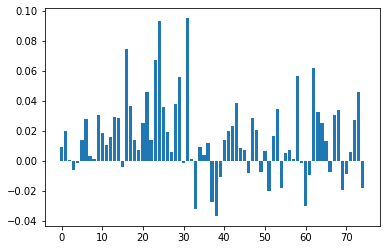

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = logistic_annual_model.coefficients
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
logis_test_annual.count()

Out[27]: 4588

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.07151932856871435, 0.10111098785128536, 0.14915758722841854, 0.12589351932606052, 0.10069164195082314, 0.10887426668321887, 0.08514574205823777, 0.05555321445050654, 0.14495455313439953, 0.07357127410513753, 0.07718028206930139, 0.1150024178491641, 0.24457248356254546, 0.07206466485816598, 0.0904362142978844, 0.048897167771714156, 0.10328061845603109, 0.10232717643891154, 0.05263305128007123, 0.10616056348245251, 0.07822075356903

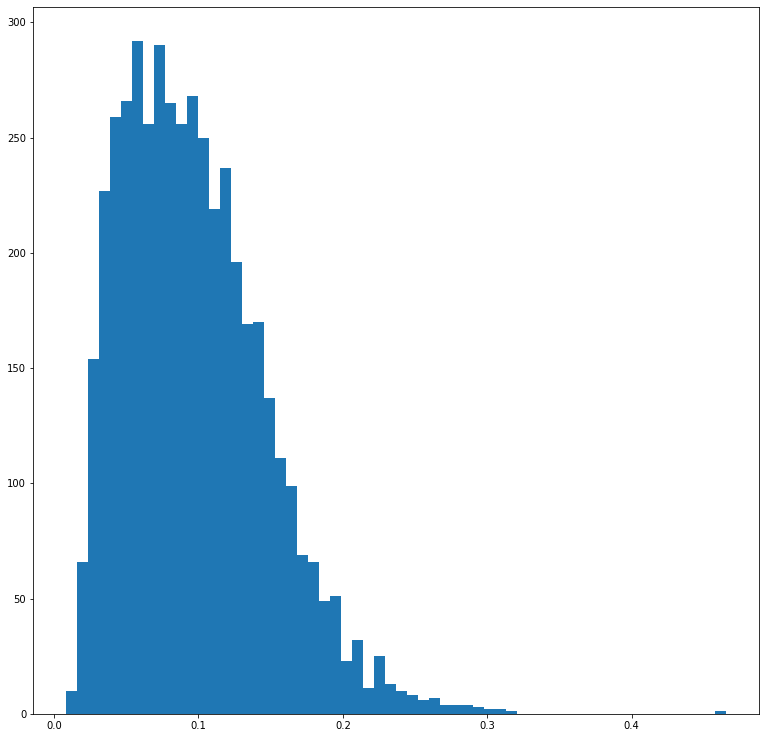

In [0]:
#1.2.6
#ToPandas and get the probility list

pd_logis=logis_test_annual.select('probability').toPandas()
pd_logis.explode("probability")
# get the list together
import matplotlib.pyplot as plt
test =[]
for i in range (0,4588):
    p=pd_logis.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)


In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =logis_test_annual.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[29]: array([[4165.,    0.],
       [ 423.,    0.]])

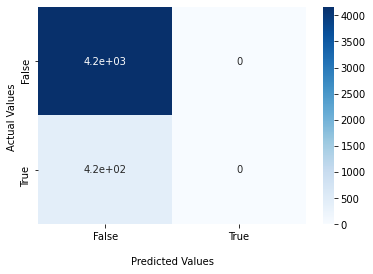

In [0]:
#Plot the confusion matrix
import seaborn as sns

ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_annual_pred=logis_test_annual.select('probability').toPandas()
pd_train_annual_pred=logis_train_annual.select('probability').toPandas()
print(pd_test_annual_pred.count(),pd_train_annual_pred.count())

probability    4588
dtype: int64 probability    2296
dtype: int64


In [0]:
test=[]
for i in range(4588):
    p = pd_test_annual_pred.probability[i][1]
    test.append(p)
y_test_annual = test_annual.select('response').toPandas()

train=[]
for i in range(2296):
    p = pd_train_annual_pred.probability[i][1]
    train.append(p)
y_train_annual = train_annual.select('response').toPandas()

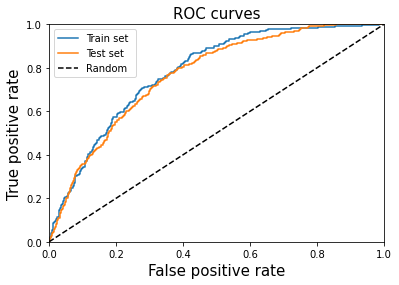

In [0]:
# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =logis_test_annual.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

the Precision: 
the prediction Response of 1:  0.0
the prediction Response of 0:  0.9078029642545772
the Recall: 
the recall for Response of 1:  0.0
the recall for Response of 0:  1.0


# Decision Tree Monthly

In [0]:
decision_tree =  DecisionTreeClassifier(labelCol='response')
#evaluate=BinaryClassificationEvaluator(labelCol = 'response')
gridsearch =  ParamGridBuilder().addGrid(decision_tree.maxDepth, [2,4,6,8]).build()
evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response') 
crossval = CrossValidator(estimator=decision_tree,
                          estimatorParamMaps=gridsearch,
                          evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response'),numFolds=3)
 
Model_cross = crossval.fit(train_monthly_scaled)
prediction = Model_cross.transform(test_monthly_scaled)

In [0]:
list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps()))

Out[35]: [(0.5,
  {Param(parent='DecisionTreeClassifier_5bb86c2a91de', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}),
 (0.5461547982550071,
  {Param(parent='DecisionTreeClassifier_5bb86c2a91de', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}),
 (0.5141483932455235,
  {Param(parent='DecisionTreeClassifier_5bb86c2a91de', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}),
 (0.5485690889784797,
  {Param(parent='DecisionTreeClassifier_5bb86c2a91de', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8})]

Feature: 0, Score: 0.00919
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.02201
Feature: 3, Score: 0.00848
Feature: 4, Score: 0.00032
Feature: 5, Score: 0.00241
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.02218
Feature: 9, Score: 0.01997
Feature: 10, Score: 0.03504
Feature: 11, Score: 0.00480
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.02301
Feature: 14, Score: 0.08974
Feature: 15, Score: 0.49847
Feature: 16, Score: 0.09093
Feature: 17, Score: 0.04562
Feature: 18, Score: 0.02505
Feature: 19, Score: 0.02079
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00303
Feature: 22, Score: 0.00918
Feature: 23, Score: 0.00819
Feature: 24, Score: 0.00306
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00334
Feature: 27, Score: 0.05517


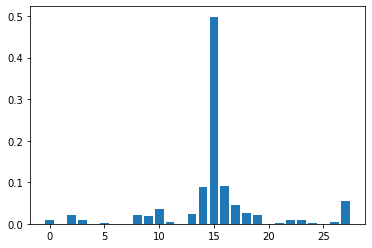

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = Model_cross.bestModel.featureImportances
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
decision_tree = DecisionTreeClassifier(featuresCol='scaledfeatures', labelCol='response',maxDepth = 8)
decision_tree_monthly_model = decision_tree.fit(train_monthly_scaled)
# transform the test data
decision_tree_test_monthly= decision_tree_monthly_model.transform(test_monthly_scaled) 
# transform the train data
decision_tree_train_monthly= decision_tree_monthly_model.transform(train_monthly_scaled) 

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.08488432770916682, 0.12892561983471074, 0.08683007893643539, 0.10146755331346022, 0.10146755331346022, 0.10146755331346022, 0.0961472894647119, 0.07827739075364154, 0.0961472894647119, 0.0961472894647119, 0.12112420670897552, 0.0961472894647119, 0.10146755331346022, 0.0961472894647119, 0.0961472894647119, 0.12112420670897552, 0.14005273952534428, 0.14005273952534428, 0.14005273952534428, 0.12112420670897552, 0.1182844243792325, 0

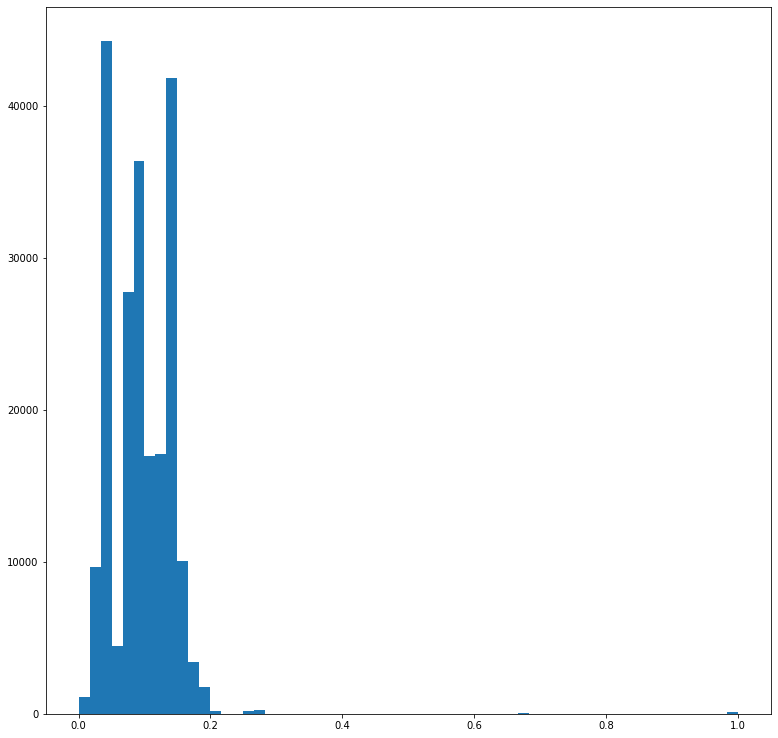

In [0]:
pd_test_monthly_pred=decision_tree_test_monthly.select('probability').toPandas()
pd_test_monthly_pred.explode("probability")
# get the list together
test =[]
for i in range (0,215679):
    p=pd_test_monthly_pred.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)


In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =decision_tree_test_monthly.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics


/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[39]: array([[1.95217e+05, 1.64000e+02],
       [2.02550e+04, 4.30000e+01]])

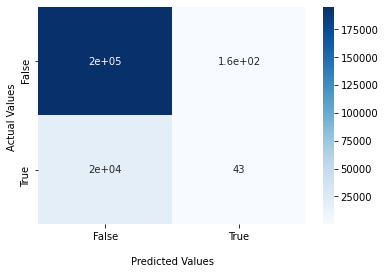

In [0]:
#Plot the confusion matrix
ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_monthly_pred=decision_tree_test_monthly.select('probability').toPandas()
pd_train_monthly_pred=decision_tree_train_monthly.select('probability').toPandas()
print(pd_test_monthly_pred.count(),pd_train_monthly_pred.count())

probability    215679
dtype: int64 probability    107869
dtype: int64


In [0]:
test=[]
for i in range(215679):
    p = pd_test_monthly_pred.probability[i][1]
    test.append(p)

y_test_monthly = test_monthly.select('response').toPandas()

train=[]
for i in range(107869):
    p = pd_train_monthly_pred.probability[i][1]
    train.append(p)

y_train_monthly = train_monthly.select('response').toPandas()

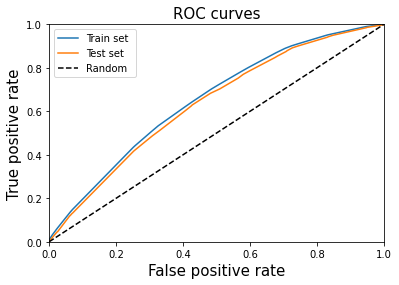

In [0]:
# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =decision_tree_test_monthly.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
the Precision: 
the prediction Response of 1:  0.20772946859903382
the prediction Response of 0:  0.9059970669042845
the Recall: 
the recall for Response of 1:  0.002118435313824022
the recall for Response of 0:  0.9991606143893214


# Decision Tree Annual

In [0]:
decision_tree =  DecisionTreeClassifier(labelCol='response')
#evaluate=BinaryClassificationEvaluator(labelCol = 'response')
gridsearch =  ParamGridBuilder().addGrid(decision_tree.maxDepth, [2,4,6,8]).build()
evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response') 
crossval = CrossValidator(estimator=decision_tree,
                          estimatorParamMaps=gridsearch,
                          evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response'),numFolds=3)
 
Model_cross = crossval.fit(train_annual_scaled)
prediction = Model_cross.transform(test_annual_scaled)

In [0]:
list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps()))

Out[46]: [(0.5578473210052157,
  {Param(parent='DecisionTreeClassifier_4f5fa19855b2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}),
 (0.695781825099187,
  {Param(parent='DecisionTreeClassifier_4f5fa19855b2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}),
 (0.6723172968511727,
  {Param(parent='DecisionTreeClassifier_4f5fa19855b2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}),
 (0.6520378234164156,
  {Param(parent='DecisionTreeClassifier_4f5fa19855b2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8})]

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.04788
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.03740
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.10533
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.16315
Feature: 17, Score: 0.09967
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.50426
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

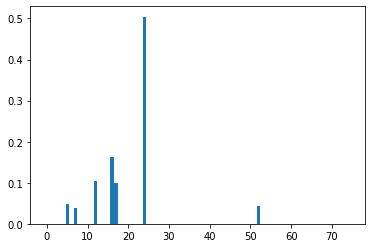

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = Model_cross.bestModel.featureImportances
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
decision_tree = DecisionTreeClassifier(featuresCol='scaledfeatures', labelCol='response',maxDepth = 4)
decision_tree_annual_model = decision_tree.fit(train_annual_scaled)
# transform the test data
decision_tree_test_annual = decision_tree_annual_model.transform(test_annual_scaled)
# transform the train data
decision_tree_train_annual= decision_tree_annual_model.transform(train_annual_scaled) 

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.01665034280117532, 0.08247422680412371, 0.20460358056265984, 0.20460358056265984, 0.06147540983606557, 0.8333333333333334, 0.20460358056265984, 0.01665034280117532, 0.20460358056265984, 0.01665034280117532, 0.01665034280117532, 0.20460358056265984, 0.20460358056265984, 0.01665034280117532, 0.20460358056265984, 0.01665034280117532, 0.20460358056265984, 0.0, 0.01665034280117532, 0.08247422680412371, 0.20460358056265984, 0.061475409

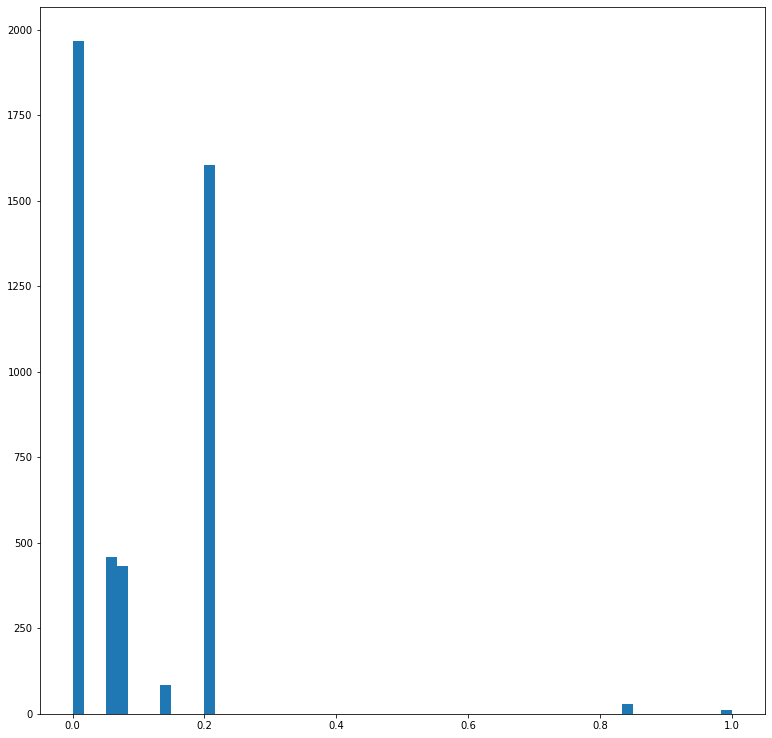

In [0]:
pd_test_annual_pred=decision_tree_test_annual.select('probability').toPandas()
pd_test_annual_pred.explode("probability")
# get the list together
test =[]
for i in range (0,4588):
    p=pd_test_annual_pred.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)

In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =decision_tree_test_annual.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[50]: array([[4.129e+03, 3.600e+01],
       [4.200e+02, 3.000e+00]])

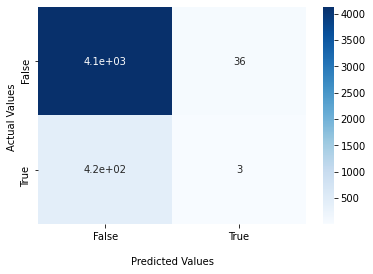

In [0]:
#Plot the confusion matrix
ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_annual_pred=decision_tree_test_annual.select('probability').toPandas()
pd_train_annual_pred=decision_tree_train_annual.select('probability').toPandas()
print(pd_test_annual_pred.count(),pd_train_annual_pred.count())

probability    4588
dtype: int64 probability    2296
dtype: int64


In [0]:
test=[]
for i in range(4588):
    p = pd_test_annual_pred.probability[i][1]
    test.append(p)

y_test_annual = test_annual.select('response').toPandas()

train=[]
for i in range(2296):
    p = pd_train_annual_pred.probability[i][1]
    train.append(p)

y_train_annual = train_annual.select('response').toPandas()

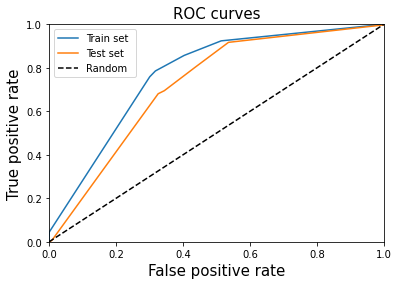

In [0]:
# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =decision_tree_test_annual.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

the Precision: 
the prediction Response of 1:  0.07692307692307693
the prediction Response of 0:  0.9076720158276544
the Recall: 
the recall for Response of 1:  0.0070921985815602835
the recall for Response of 0:  0.9913565426170469


# Random Forest monthly

In [0]:
random_forest = RandomForestClassifier(featuresCol='scaledfeatures',labelCol = 'response')
gridsearch = ParamGridBuilder().addGrid(random_forest.maxDepth, [2,4,6,8]).build()
evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response') 
crossval = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=gridsearch,
                          evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response'),numFolds=3)
Model_cross = crossval.fit(train_monthly_scaled)
prediction = Model_cross.transform(test_monthly_scaled)

In [0]:
#Find best hyperparameter
list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps()))

Out[59]: [(0.5311343199953354,
  {Param(parent='RandomForestClassifier_c473c4ef3e5a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}),
 (0.6318989059203902,
  {Param(parent='RandomForestClassifier_c473c4ef3e5a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}),
 (0.6370346222930542,
  {Param(parent='RandomForestClassifier_c473c4ef3e5a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}),
 (0.6392133379664257,
  {Param(parent='RandomForestClassifier_c473c4ef3e5a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8})]

Feature: 0, Score: 0.01468
Feature: 1, Score: 0.00392
Feature: 2, Score: 0.01601
Feature: 3, Score: 0.01937
Feature: 4, Score: 0.01669
Feature: 5, Score: 0.00606
Feature: 6, Score: 0.00820
Feature: 7, Score: 0.00391
Feature: 8, Score: 0.07681
Feature: 9, Score: 0.02810
Feature: 10, Score: 0.05831
Feature: 11, Score: 0.01605
Feature: 12, Score: 0.01226
Feature: 13, Score: 0.00986
Feature: 14, Score: 0.13051
Feature: 15, Score: 0.22435
Feature: 16, Score: 0.11300
Feature: 17, Score: 0.11157
Feature: 18, Score: 0.04196
Feature: 19, Score: 0.01520
Feature: 20, Score: 0.00558
Feature: 21, Score: 0.00541
Feature: 22, Score: 0.00461
Feature: 23, Score: 0.00580
Feature: 24, Score: 0.00630
Feature: 25, Score: 0.00375
Feature: 26, Score: 0.00745
Feature: 27, Score: 0.03424


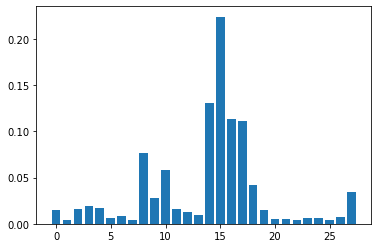

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = Model_cross.bestModel.featureImportances
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
random_forest = RandomForestClassifier(featuresCol='scaledfeatures', labelCol='response',maxDepth = 8)
random_forest_monthly_model = random_forest.fit(train_monthly_scaled)
# transform the test data
random_forest_test_monthly= random_forest_monthly_model.transform(test_monthly_scaled) 
# transform the train data
random_forest_train_monthly= random_forest_monthly_model.transform(train_monthly_scaled) 

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.07463586528333549, 0.0912646674175341, 0.06727831693412112, 0.1093769241037642, 0.10357204040114354, 0.10302936857885314, 0.07652687887380044, 0.07319838619261734, 0.07553939565335899, 0.0772213922441526, 0.11351749193668229, 0.08360050199674494, 0.10109435684608561, 0.09291281160581236, 0.09373732044502739, 0.10244849968829572, 0.13054124005632262, 0.12212127558082883, 0.12469116403028269, 0.11403035077459216, 0.1142957503882444

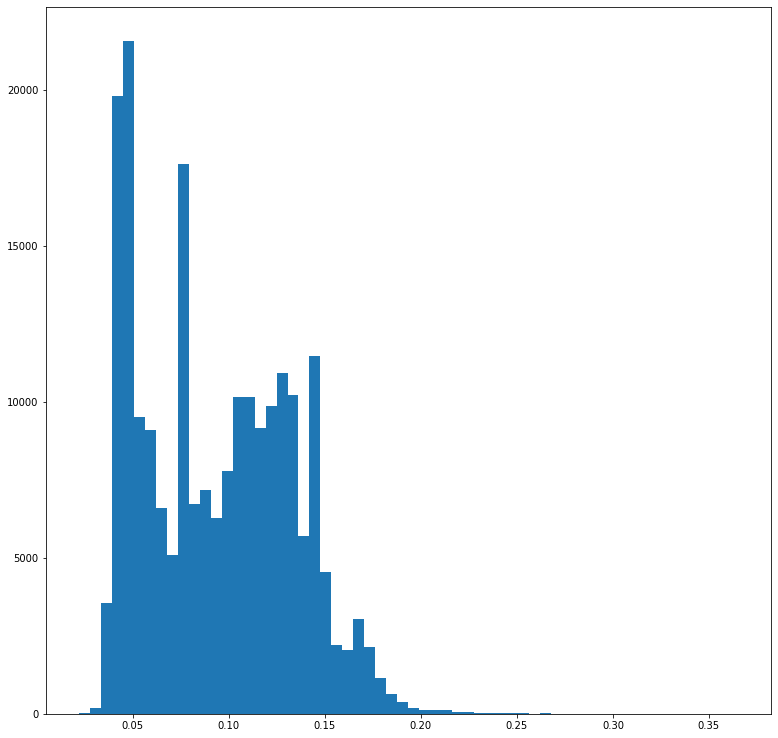

In [0]:
pd_test_monthly_pred=random_forest_test_monthly.select('probability').toPandas()
pd_test_monthly_pred.explode("probability")
# get the list together
test =[]
for i in range (0,215679):
    p=pd_test_monthly_pred.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)

In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =random_forest_test_monthly.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[72]: array([[195381.,      0.],
       [ 20298.,      0.]])

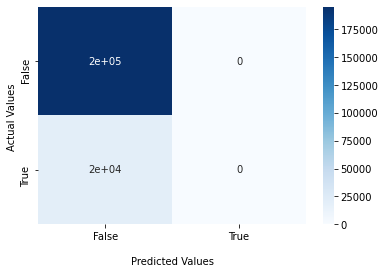

In [0]:
#Plot the confusion matrix
ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_monthly_pred=random_forest_test_monthly.select('probability').toPandas()
pd_train_monthly_pred=random_forest_train_monthly.select('probability').toPandas()
print(pd_test_monthly_pred.count(),pd_train_monthly_pred.count())

probability    215679
dtype: int64 probability    107869
dtype: int64


In [0]:
test=[]
for i in range(215679):
    p = pd_test_monthly_pred.probability[i][1]
    test.append(p)

y_test_monthly = test_monthly.select('response').toPandas()

train=[]
for i in range(107869):
    p = pd_train_monthly_pred.probability[i][1]
    train.append(p)

y_train_monthly = train_monthly.select('response').toPandas()

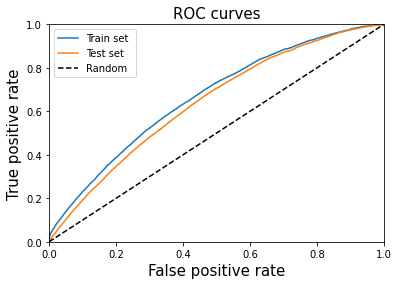

In [0]:
# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =random_forest_test_monthly.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
the Precision: 
the prediction Response of 1:  0.0
the prediction Response of 0:  0.9058879167651928
the Recall: 
the recall for Response of 1:  0.0
the recall for Response of 0:  1.0


# Random Forest Annual

In [0]:
random_forest = RandomForestClassifier(featuresCol='scaledfeatures',labelCol = 'response')
gridsearch = ParamGridBuilder().addGrid(random_forest.maxDepth, [2,4,6,8]).build()
evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response') 
crossval = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=gridsearch,
                          evaluator = ev.BinaryClassificationEvaluator(labelCol = 'response'),numFolds=3)
Model_cross = crossval.fit(train_annual_scaled)
prediction = Model_cross.transform(test_annual_scaled)

In [0]:
#Find best hyperparameter
list(zip( Model_cross.avgMetrics,Model_cross.getEstimatorParamMaps()))

Out[79]: [(0.676164176695706,
  {Param(parent='RandomForestClassifier_0c3722ec49d4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2}),
 (0.7363048499432571,
  {Param(parent='RandomForestClassifier_0c3722ec49d4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4}),
 (0.7252865571642962,
  {Param(parent='RandomForestClassifier_0c3722ec49d4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}),
 (0.7017218250313154,
  {Param(parent='RandomForestClassifier_0c3722ec49d4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8})]

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01021
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00541
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00354
Feature: 7, Score: 0.03074
Feature: 8, Score: 0.01302
Feature: 9, Score: 0.01018
Feature: 10, Score: 0.00862
Feature: 11, Score: 0.00673
Feature: 12, Score: 0.00924
Feature: 13, Score: 0.02403
Feature: 14, Score: 0.01294
Feature: 15, Score: 0.01016
Feature: 16, Score: 0.04182
Feature: 17, Score: 0.05471
Feature: 18, Score: 0.00215
Feature: 19, Score: 0.00387
Feature: 20, Score: 0.02426
Feature: 21, Score: 0.04414
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.03614
Feature: 24, Score: 0.16037
Feature: 25, Score: 0.01875
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00070
Feature: 28, Score: 0.04249
Feature: 29, Score: 0.08063
Feature: 30, Score: 0.00554
Feature: 31, Score: 0.07523
Feature: 32, Score: 0.02884
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00607
Feature: 35, Score: 0.00000
Fe

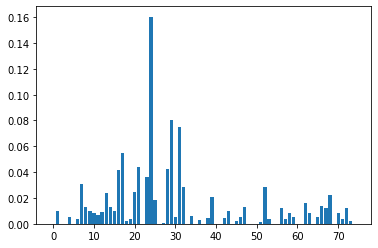

In [0]:
#part 1.2.5 Plot coefficient values or feature importance.
# get importance
importance = Model_cross.bestModel.featureImportances
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
random_forest = RandomForestClassifier(featuresCol='scaledfeatures', labelCol='response',maxDepth = 4)
random_forest_annual_model = random_forest.fit(train_annual_scaled)
# transform the test data
random_forest_test_annual= random_forest_annual_model.transform(test_annual_scaled) 
# transform the train data
random_forest_train_annual= random_forest_annual_model.transform(train_annual_scaled) 

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
[0.05759073418456277, 0.10607796985053382, 0.1430958626048109, 0.15438424884145496, 0.1289689068955588, 0.12161013677726011, 0.1872905228477103, 0.07286562982864739, 0.14496602943858156, 0.07824895409108719, 0.06751916590813303, 0.1430958626048109, 0.2196545334012066, 0.060555838236384885, 0.1409850087309357, 0.05369295509654694, 0.13295368656752962, 0.20164099279793307, 0.05466242233698839, 0.12213784513597777, 0.10577166207934204,

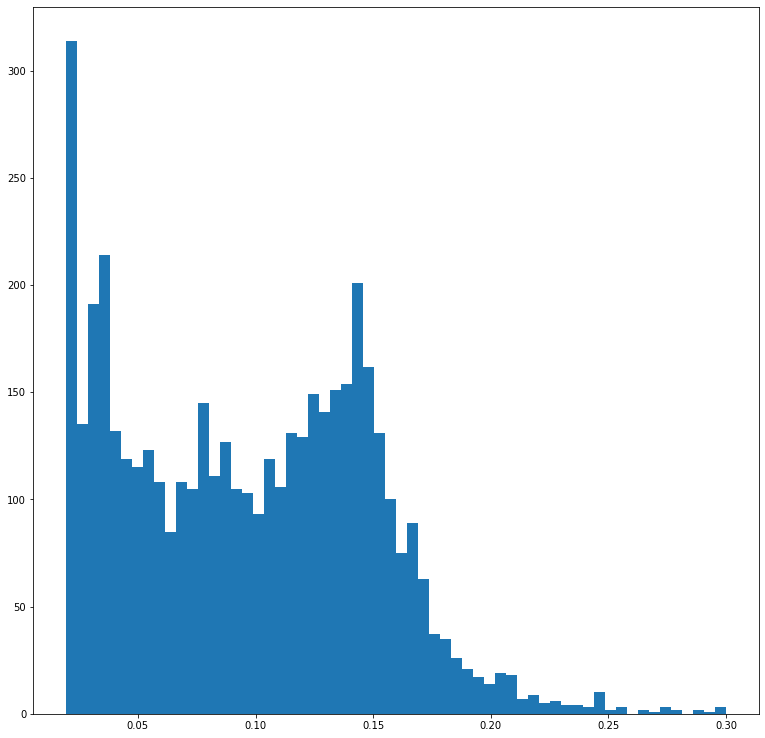

In [0]:
pd_test_annual_pred=random_forest_test_annual.select('probability').toPandas()
pd_test_annual_pred.explode("probability")
# get the list together
test =[]
for i in range (0,4588):
    p=pd_test_annual_pred.probability[i][1]
    test.append(p)
print(test)
#draw the histogram
plt.figure(figsize=(13,13))
plt.hist(test,bins=60)

In [0]:
# part 1.2.7 Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
#combine the prediction and the labels
preds_and_labels =random_forest_test_annual.select('prediction','response')
preds_and_labels = preds_and_labels.rdd
# confusion matrix
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrics=metrics.confusionMatrix().toArray()
confusion_matrics

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[83]: array([[4165.,    0.],
       [ 423.,    0.]])

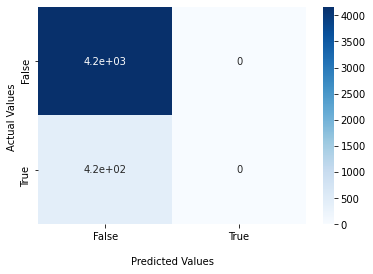

In [0]:
#Plot the confusion matrix
ax = sns.heatmap(confusion_matrics, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [0]:
pd_test_annual_pred=random_forest_test_annual.select('probability').toPandas()
pd_train_annual_pred=random_forest_train_annual.select('probability').toPandas()
print(pd_test_annual_pred.count(),pd_train_annual_pred.count())

probability    4588
dtype: int64 probability    2296
dtype: int64


In [0]:
test=[]
for i in range(4588):
    p = pd_test_annual_pred.probability[i][1]
    test.append(p)

y_test_annual = test_annual.select('response').toPandas()

train=[]
for i in range(2296):
    p = pd_train_annual_pred.probability[i][1]
    train.append(p)

y_train_annual = train_annual.select('response').toPandas()

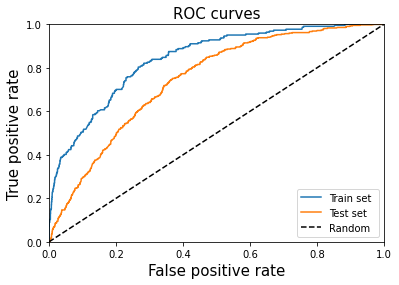

In [0]:
# Scores 
scores_train = train
scores_test = test
# ROC 
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
# AUC 
auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set ');
plt.plot(fpr_test, tpr_test, label='Test set ');
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random ');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('ROC curves', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xlabel('False positive rate', fontsize = 15)
plt.legend()
plt.show()

In [0]:
preds_and_labels =random_forest_test_annual.select(['prediction', 'response'])
preds_and_labels = preds_and_labels.rdd
metrics = MulticlassMetrics(preds_and_labels)
#Calaulate the precision and recall
# Precision:
print('the Precision: ')
print('the prediction Response of 1: ', metrics.precision(1.0))
print('the prediction Response of 0: ', metrics.precision(0.0))
 
# Recall
print('the Recall: ')
print('the recall for Response of 1: ', metrics.recall(1.0))
print('the recall for Response of 0: ', metrics.recall(0.0))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
the Precision: 
the prediction Response of 1:  0.0
the prediction Response of 0:  0.9078029642545772
the Recall: 
the recall for Response of 1:  0.0
the recall for Response of 0:  1.0


# 1.3 Comparison of method

| Top feature importance features  | Probability distribution | Confusion matrix                      | Roc                           | Precision                                   | recall                            |
| -------------------------------  | ------------------------ | ------------------------------------- | ----------------------------- | ------------------------------------------- | ----------------------------------
| 13,14,15                         | Right skewed             | TN = 195381,FP = 0, FN = 20298, TP = 0| train and test and very close | precision of 1: 0.0, precision of 0: 0.9059 | recall of 1: 0.0 recall of 0:  1.0

| Top feature importance features  | Probability distribution | Confusion matrix                      | Roc                           | Precision                                   | recall                            |
| -------------------------------  | ------------------------ | ------------------------------------- | ----------------------------- | ------------------------------------------- | ----------------------------------
| 24,14,29                         | Right skewed             | TN = 4165,FP = 0, FN = 423, TP = 0    | train and test and very close | precision of 1: 0.0, precision of 0: 0.9078 | recall of 1: 0.0 recall of 0:  1.0

| Top feature importance features  | Probability distribution | Confusion matrix                      | Roc                           | Precision                                   | recall                                 |
| -------------------------------  | ------------------------ | ------------------------------------- | ----------------------------- | ------------------------------------------- | ----------------------------------     |
| 15,14,16                         | No significant trend     | TN=1.95e+05,FP=0,FN=2.02e+04,TP=0     | train and test and very close | precision of 1: 0.208,precision of 0: 0.906 | recall of 1: 0.002,recall of 0:  0.999 |

| Top feature importance features  | Probability distribution | Confusion matrix                              | Roc                           | Precision                                   | recall                                 |
| -------------------------------  | ------------------------ | -------------------------------------         | ----------------------------- | ------------------------------------------- | ----------------------------------     |
| 24,12,15                         | No significant trend     | TN=4.13e+03,FP=3.6e+01,FN=4.2e+02,TP=3e+0     | train and test and very close | precision of 1: 0.0769,precision of 0: 908 | recall of 1: 0.007,recall of 0:  0.991 |

| Top feature importance features  | Probability distribution | Confusion matrix                      | Roc                           | Precision                                   | recall                            |
| -------------------------------  | ------------------------ | ------------------------------------- | ----------------------------- | ------------------------------------------- | ----------------------------------
| 15,14,16                         | Right skewed             | TN = 195381,FP = 0, FN = 20298, TP = 0| train and test and very close | precision of 1: 0.0, precision of 0: 0.90598| recall of 1: 0.0 recall of 0:  1.0|

| Top feature importance features  | Probability distribution | Confusion matrix                      | Roc                               | Precision                                   | recall                            |
| -------------------------------  | ------------------------ | ------------------------------------- | -----------------------------     | ------------------------------------------- | ----------------------------------
| 28,24,31                         | Right skewed             | TN = 4165,FP = 0, FN = 423, TP = 0    | train and test have similar trend | precision of 1: 0.0, precision of 0: 0.90780| recall of 1: 0.0 recall of 0:  1.0|

## Which combination of feature engineering and modeling approach do you select as the best to deploy in a production environment and why?

I would choose the logistic regression model because out of the three models, it's highest score is a lot higher than random forest and decision tree.
For monthly data and annual data, I prefer to use annual data because it has more features than monthly data,so it will help setting up our model to perform better especially our dataset have enormous smaples.